🧠 Questão 1: Classificação de E-mails como Spam ou Não Spam

Você possui um conjunto de dados com e-mails rotulados como "spam" ou "não spam".​ Utilize um algoritmo de aprendizado supervisionado para treinar um modelo que classifique novos e-mails.​

* Considere usar o Regressão Logística.​

* Transforme o texto dos e-mails em vetores numéricos usando técnicas como TF-IDF.

📁 Dataset usado: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [13]:
import pandas as pd

# sep='\t' → define o caractere que separa as colunas no arquivo.
# \t → é o tab (tabulação), que é o separador usado nesse dataset.
# header=None → indica que o arquivo não tem cabeçalho (nomes das colunas).
# Se não colocar isso, o Pandas pode achar que a primeira linha do arquivo é o nome das colunas, o que ia atrapalhar nesse caso.
# Tive problemas por isso antes.
dados = pd.read_csv('SMSSpamCollection', sep='\t', header=None)

# A coluna 0 é o rótulo/label (ham = não é spam, spam = é spam) e a 1 é o texto da mensagem.
dados.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# Renomeando as colunas para facilitar o entendimento
dados.columns = ['label', 'mensagem']
dados.head()

,label,mensagem
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Vou dar uma olhada básica nos dados. Talvez seja interessante ver quantas mensagens são spam e quantas não são spam? Isso ajuda a ter noção de balanceamento das classes.

In [15]:
dados['label'].value_counts()
# (O dataset está desbalanceado) — tem muito mais mensagens "ham" (4825) do que "spam" (747).
# Isso pode influenciar o modelo mais pra frente, mas eu posso ver como lidar com isso depois, caso seja necessário.

,count
label,
ham,4825
spam,747


Usando libs, vou:

* Separar X e y (texto e rótulo)

* Converter os textos com TF-IDF

* Treinar um modelo simples (Regressão Logística)

Mas vou por partes. Primeiro, vou transformar os rótulos de texto (“ham” e “spam”) em algo numérico, pra poder treinar o modelo depois.

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(dados['label'])  # ham vira 0, spam vira 1

Agora vou vetorizar os textos com TF-IDF.

O TfidfVectorizer do sklearn já cuida da tokenização, lowercase e stopwords se a gente quiser.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vetorizador = TfidfVectorizer(stop_words='english')
X = vetorizador.fit_transform(dados['mensagem'])

# Isso vai te dizer quantas mensagens e quantas features (palavras únicas) foram geradas.
X.shape

(5572, 8444)

Boa! Isso significa que nós temos:

* 5572 mensagens

* 8444 palavras únicas (depois de remover stopwords em inglês)

Ou seja, o meu modelo agora tem uma matriz 5572 × 8444, onde cada linha é uma mensagem representada por pesos TF-IDF de cada palavra.

Agora vamos separar o **Treino** x **Teste**:

In [20]:
from sklearn.model_selection import train_test_split

# Separar em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Regressão Logística
from sklearn.linear_model import LogisticRegression

# O .fit() vai treinar o modelo com meus dados de treino. Depois a gente faz as previsões e avalia.
modelo = LogisticRegression()
modelo.fit(X_treino, y_treino)

LogisticRegression()

In [23]:
# Modelo treinado 🧠✨
# Agora bora ver como ele se saiu. Vamos fazer as previsões com os dados de teste:

y_pred = modelo.predict(X_teste)

from sklearn.metrics import classification_report, confusion_matrix

# E depois avaliar com algumas métricas:
print(confusion_matrix(y_teste, y_pred))
print(classification_report(y_teste, y_pred))


[[1447    1]
 [  70  154]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1448
           1       0.99      0.69      0.81       224

    accuracy                           0.96      1672
   macro avg       0.97      0.84      0.89      1672
weighted avg       0.96      0.96      0.95      1672



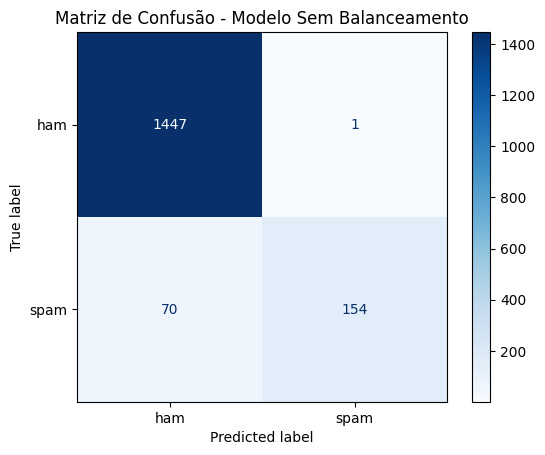

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Matriz de confusão do primeiro modelo
cm = confusion_matrix(y_teste, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')  # você pode mudar o cmap se quiser
plt.title("Matriz de Confusão - Modelo Sem Balanceamento")
plt.show()

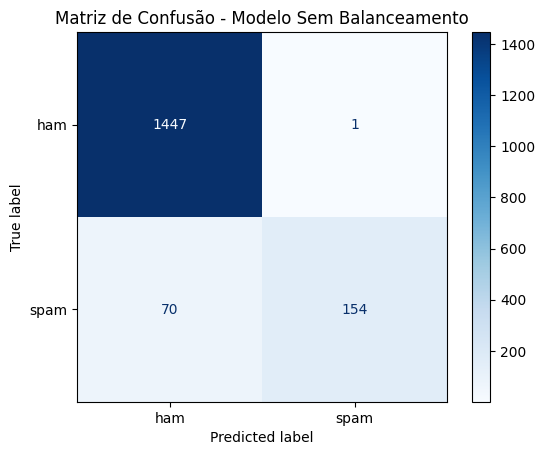

* 1447: verdadeiros negativos (ham corretamente classificados)

* 1: falso positivo (ham que virou spam)

* 70: falsos negativos (spam que virou ham) ← aqui está o talvez a "fraqueza" do modelo

* 154: verdadeiros positivos (spam corretamente classificados)


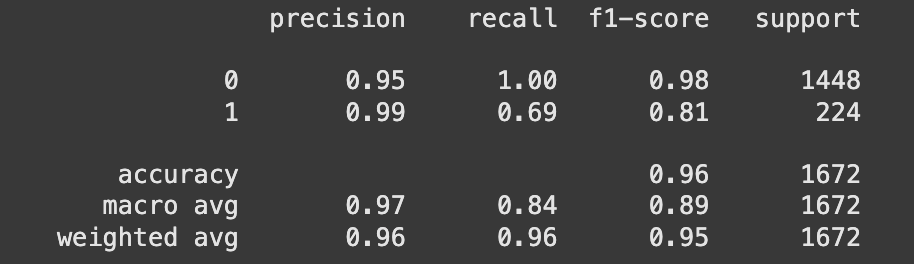

Classe 0 (ham):

* Precision 0.95 → dos que ele chamou de "ham", 95% eram mesmo ham

* Recall 1.00 → ele pegou praticamente todos os hams (só errou 1)

* F1-score 0.98 → excelente equilíbrio entre precisão e recall

Classe 1 (spam):

* Precision 0.99 → dos que ele classificou como spam, 99% eram mesmo spam

* Recall 0.69 → mas ele deixou passar 31% dos spams

* F1-score 0.81 → bom, mas com espaço pra melhorar